In [77]:
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)

In [78]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [79]:
#import t=privachy version 
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***I make datasets with few samples but with many features to force the target model to overfit.***


***NOTE JIM: had to make batch_size 25 so DP optimizer would run with same hyperparams

In [80]:
n_classes = 2

# (X,y): Original distribution
X, y = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=42
                          )
yd = np.eye(n_classes)[yd]




In [81]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(Xt, yt, test_size=0.5, shuffle=False)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8)
    )
).flatten()

### Define the target model architecture

*Again, I'm using a rather big model (for the classification task) to favour overfitting.*

In [82]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)

input_data = Input(shape = Xt_member[0].shape)
x = Dense(128, activation='relu')(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

## Now try the SafeKerasModel version

In [83]:
import importlib
import safemodel
from safemodel.classifiers.safekeras import Safe_KerasModel



importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel



In [84]:
optimizer=None
safeModel = Safe_KerasModel(inputs= input_data, outputs=output,name="safekeras-test")


args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_5')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_19')>, 'name': 'safekeras-test'}
- parameter optimizer = None identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.Nothing currently implemented to change type of parameter optimizer from NoneType to tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.



In [85]:
#safeModel.__dict__


In [86]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)


safeModel.compile(loss=loss)#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [87]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_optimizer_is_DP(safeModel.optimizer)
print(f' It is {dpused} that the moddel will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the moddel will be DP because optimiser does  contain key _was_dp_gradients_called so should be DP.


(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
Current epsilon is 50.301726361197794
this is not going to be ok do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 3s 48ms/step - loss: 6.0048 - accuracy: 0.5080 - val_loss: 3.6714 - val_accuracy: 0.4840
Epoch 2/20
10/10 [==============================] - 0s 39ms/step - loss: 2.6514 - accuracy: 0.5520 - val_loss: 2.4819 - val_accuracy: 0.5120
Epoch 3/20
10/10 [==============================] - 0s 42ms/step - loss: 1.9131 - accuracy: 0.5960 - val_loss: 2.3019 - val_accuracy: 0.5400
Epoch 4/20
10/10 [==============================] - 0s 42ms/step - loss: 1.5606 - accuracy: 0.6480 - val_loss: 2.3071 - val_accuracy: 0.5760
Epoch 5/20
10/10 [==============================] - 0s 41ms/step - loss: 1.3814 - accuracy: 0.7200 - val_loss: 2.1375 - val_accuracy: 0.600

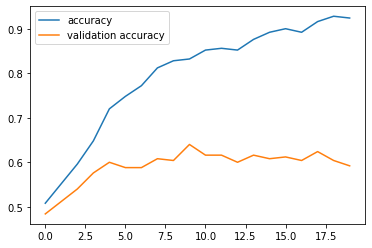

In [88]:
epochs = 20
batch_size = 25

r_DP = safeModel.fit(Xt_member, 
              yt_member, 
              validation_data=(Xt_nonmember, yt_nonmember),
              epochs=epochs, 
              batch_size=batch_size
)  


plt.plot(r_DP.history['accuracy'], label='accuracy')
plt.plot(r_DP.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show() 


In [89]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_DP_used(safeModel.optimizer)
print(f' It is {dpused} that the model will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimiser has been run


## compute privacy

In [90]:
print(f'dataset has {Xt.shape[0]} entries so batch size is {100*safeModel.batch_size/Xt.shape[0]}%')
privacy = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=Xt.shape[0],
                                              batch_size=safeModel.batch_size,
                                              noise_multiplier=safeModel.noise_multiplier,
                                              epochs=25,#epochs,
                                              delta=1e-5)
print(f'with these settings privacy = {privacy}')

dataset has 500 entries so batch size is 5.0%
DP-SGD with sampling rate = 5% and noise_multiplier = 0.5 iterated over 500 steps satisfies differential privacy with eps = 43.9 and delta = 1e-05.
The optimal RDP order is 1.5.
with these settings privacy = (43.85228589564216, 1.5)


In [91]:
safeModel.save('safekeras.sav')

INFO:tensorflow:Assets written to: safekeras.sav/assets


In [92]:
safeModel.preliminary_check()

- parameter optimizer = <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fca8d8af9a0> identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.


('WARNING: model parameters may present a disclosure risk:\n- parameter optimizer = <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fca8d8af9a0> identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.',
 True)

In [93]:
for key,value in safeModel.__dict__.items():
     print (f'thing associated with key {key} has type {type(value)}')

thing associated with key _self_setattr_tracking has type <class 'bool'>
thing associated with key _obj_reference_counts_dict has type <class 'keras.utils.object_identity.ObjectIdentityDictionary'>
thing associated with key inputs has type <class 'list'>
thing associated with key outputs has type <class 'list'>
thing associated with key _is_model_for_instrumentation has type <class 'bool'>
thing associated with key _instrumented_keras_api has type <class 'bool'>
thing associated with key _instrumented_keras_layer_class has type <class 'bool'>
thing associated with key _instrumented_keras_model_class has type <class 'bool'>
thing associated with key _trainable has type <class 'bool'>
thing associated with key _stateful has type <class 'bool'>
thing associated with key built has type <class 'bool'>
thing associated with key _input_spec has type <class 'NoneType'>
thing associated with key _build_input_shape has type <class 'tensorflow.python.framework.tensor_shape.TensorShape'>
thing ass

In [94]:
all_keys = []
unusuals =[]
tuples =[]
deleted_keys = []

print("===============================================================================================")
print("Tuples")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == tuple):
        print (f'thing associated with key {key} has type {type(value)}')
        tuples.append(key)

print("===============================================================================================")
print("Bools")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == bool):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Lists")
print("===============================================================================================")        
for key,value in safeModel.__dict__.items():
    if(type(value) == list):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Strings")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == str):
        print (f'thing associated with key {key} has type {type(value)}')

        
print("===============================================================================================")
print("Ints")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == int):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Floats")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == float):
        print (f'thing associated with key {key} has type {type(value)}')
        
print("===============================================================================================")
print("Dicts")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == dict):
        print (f'thing associated with key {key} has type {type(value)}')

        
print("===============================================================================================")
print("Sets")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == set):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Unusual Ones")
print("===============================================================================================")

        
for key,value in safeModel.__dict__.items():
    if((type(value) != int) and (type(value) != str) and 
       (type(value) != list) and (type(value) != bool) and 
       (type(value) != tuple) and (type(value) != float) and
       (type(value) != dict) and (type(value) != set)):
        print (f'thing associated with key {key} has type {type(value)}')
        unusuals.append(key)

Tuples
thing associated with key _saved_model_arg_spec has type <class 'tuple'>
Bools
thing associated with key _self_setattr_tracking has type <class 'bool'>
thing associated with key _is_model_for_instrumentation has type <class 'bool'>
thing associated with key _instrumented_keras_api has type <class 'bool'>
thing associated with key _instrumented_keras_layer_class has type <class 'bool'>
thing associated with key _instrumented_keras_model_class has type <class 'bool'>
thing associated with key _trainable has type <class 'bool'>
thing associated with key _stateful has type <class 'bool'>
thing associated with key built has type <class 'bool'>
thing associated with key _supports_masking has type <class 'bool'>
thing associated with key _autocast has type <class 'bool'>
thing associated with key _expects_training_arg has type <class 'bool'>
thing associated with key _expects_mask_arg has type <class 'bool'>
thing associated with key _dynamic has type <class 'bool'>
thing associated wi

In [95]:
#safeModel.request_release('safekeras.pkl') # TypeError: cannot pickle '_thread.RLock' object

#safeModel.request_release('safekeras.sav') # TypeError: cannot pickle '_thread.RLock' object

#safeModel.request_release('safekeras.tf')




safeModel.save('my_model')
safeModel.save_weights('weights.h5')

safeModel.request_release('safe.sav')

INFO:tensorflow:Assets written to: my_model/assets
INFO:tensorflow:Assets written to: safe.sav/assets
copying _self_setattr_tracking
...done
copying _obj_reference_counts_dict
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...done
copying inputs
...done
copying outputs
...done
copying _is_model_for_instrumentation
...done
copying _instrumented_keras_api
...done
copying _instrumented_keras_layer_class
...done
copying _instrumented_keras_model_class
...done
copying _trainable
...done
copying _stateful
...done
copying built
...done
copying _input_spec
...done
copying _build_input_shape
...done
copying _saved_model_inputs_spec
...done
copying _saved_model_arg_spec
...done
copying _supports_masking
...done
copying _name
...done
copying _activity_regularizer
...done
copying _trainable_weights
...done
copying _non_trainable_weights
...done
copying _updates
...done
copying _thread_local
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...done
copying _cal

In [ ]:
#keepers = ['_network_nodes']

#for i in range(0,len(unusuals)):
#    if(safeModel.__dict__[unusuals[i]] in keepers ):
#        pass
#    else:
#        del safeModel.__dict__[unusuals[i]]
    
#for i in range(0,len(tuples)):
#    del safeModel.__dict__[tuples[i]]

#required
#del safeModel.compiled_metrics
#del safeModel.compiled_loss
# we need safeModel._nested_inputs 
# we need safeModel._nested_outputs 
# we need safeModel.optimizer 
# we need safeModel.compiled_loss 
# we need safeModel.compiled_metrics 

del safeModel._saved_model_arg_spec 
del safeModel._self_setattr_tracking 
del safeModel._is_model_for_instrumentation 
del safeModel._instrumented_keras_api 
del safeModel._instrumented_keras_layer_class
del safeModel._instrumented_keras_model_class 
del safeModel._trainable 
del safeModel._stateful 
del safeModel.built 
del safeModel._supports_masking 
del safeModel._autocast 
del safeModel._expects_training_arg 
del safeModel._expects_mask_arg
del safeModel._dynamic 
del safeModel._auto_track_sub_layers 
del safeModel._preserve_input_structure_in_config 
#we need safeModel._is_graph_network 
del safeModel._compute_output_and_mask_jointly 
del safeModel._base_model_initialized
del safeModel._enable_dict_to_input_mapping 
# we need safeModel._is_compiled 
del safeModel.stop_training 

#lists
del safeModel.inputs 
# we need safeModel.outputs
# we nedd safeModel._trainable_weights 
# we need safeModel._non_trainable_weights 
del safeModel._updates 
del safeModel._callable_losses 
del safeModel._losses 
del safeModel._metrics 
# we need safeModel._self_tracked_trackables 
del safeModel._inbound_nodes_value 
del safeModel._outbound_nodes_value 
del safeModel.input_names 
del safeModel.output_names 
#we need safeModel._input_layers 
#we need safeModel._output_layers 
# we need safeModel._input_coordinates 
#we need safeModel._output_coordinates 
del safeModel._feed_input_names  
del safeModel._feed_inputs 
del safeModel._feed_input_shapes 
del safeModel._self_unconditional_checkpoint_dependencies 

del safeModel._outer_name_scope 
del safeModel.model_save_file 
del safeModel.filename 
del safeModel.researcher 
#we need safeModel.model_type 

del safeModel._self_update_uid 
del safeModel.min_epsilon 
del safeModel.batch_size 

del safeModel.delta 
del safeModel.l2_norm_clip 
del safeModel.noise_multiplier 
del safeModel.learning_rate 

#these are dicts
del safeModel._output_mask_cache 
del safeModel._output_tensor_cache
del safeModel._output_shape_cache 
del safeModel._layer_call_argspecs 
del safeModel._self_unconditional_dependency_names 
del safeModel._self_unconditional_deferred_dependencies 
del safeModel._self_saveable_object_factories

#these are sets
# we need safeModel._network_nodes
del safeModel._self_name_based_restores 

#the weird ones
del safeModel._steps_per_execution 
del safeModel._train_counter
del safeModel._test_counter 
del safeModel._predict_counter 

del safeModel._nodes_by_depth 
del safeModel._tensor_usage_count 
del safeModel.model 
del safeModel.saved_model 
del safeModel.ignore_items 
del safeModel.examine_seperately_items 
del safeModel.num_microbatches 
del safeModel._run_eagerly 

del safeModel.loss 
del safeModel._jit_compile 
del safeModel.history 
del safeModel.train_function 
del safeModel.test_function 
del safeModel.predict_function 
del safeModel.train_tf_function 

safeModel.request_release('safekeras.h5')

In [ ]:
# create and fit using recommended params
print("***Test 1: researcher doesn't change recommended params")
safeKerasModel1 = Safe_KerasModel(input_data, output)
safeKerasModel1.compile()
safeKerasModel1.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel1.save(name="safe1.pkl")
safeKerasModel1.preliminary_check()
safeKerasModel1.request_release(filename="safe1.pkl")


# change model params to recommended values
print("\n***Test 2: researcher changes params safely")
safeKerasModel2 = Safe_KerasModel(input_data, output)
safeKerasModel2.compile()
safeKerasModel2.optimizer="DPAdam"
safeKerasModel2.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel2.save(name="safe2.pkl")
safeKerasModel2.preliminary_check()
safeKerasModel2.request_release(filename="safe2.pkl")

# change one model params in an unsafe way
print("\n***Test 3: researcher changes string params unsafely")
safeKerasModel3 = Safe_KerasModel(input_data, output)
safeKerasModel3.compile()
safeKerasModel3.optimizer="Adam"
safeKerasModel3.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel3.save(name="unsafe3.pkl")
safeKerasModel3.preliminary_check()
safeKerasModel3.request_release(filename="unsafe3.pkl")

# change another model params in an  unsafe way


# change another model params in an  unsafe way
print("\n***Test 5: researcher changes string and numeric params unsafely")


In [ ]:
# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 6: researcher changes string and numeric params unsafely")
safeKerasModel6 = Safe_KerasModel(input_data, output)
safeKerasModel6.compile()
safeKerasModel6.optimizer="Adam"
safeKerasModel6.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel6.save(name="unsafe6.pkl")
safeKerasModel6.preliminary_check(apply_constraints=False)
safeKerasModel6.request_release(filename="unsafe6.pkl")